## Table of Contents

* [Chapter 1](#chapter1): Transfer Learning with Pre-trained Models
    * [Section 1.1](#section_1_1): Guhr
    * [Section 1.2](#section_1_2): Mdraw
    * [Section 1.3](#section_1_3): Nlptown
    * [Section 1.4](#section_1_4): PyABSA
* [Chapter 2](#chapter2): Fine-tuning of Best-Performing Pre-trained Model
* [Chapter 3](#chapter3): Deep Learning from Scratch
    * [Section 3.1](#section_3_1): Sequential Neural Network with Self-trained Embeddings
* [Chapter 4](#chapter4): Propagation

## Chapter 1: <a class="anchor" id="chapter1"></a> Transfer Learning with Pre-trained Models

In [1]:
#Performing required installations
#pip install germansentiment
#pip install pyabsa
#pip install tensorflow

In [2]:
#Importing libraries
#Data processing
import pandas as pd
import numpy as np
import re
from typing import List

#Sentiment analysis
from germansentiment import SentimentModel

#Machine and deep learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

from transformers import AutoModelForSequenceClassification, AutoTokenizer, TextClassificationPipeline, BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pyabsa import APCCheckpointManager, available_checkpoints

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l1, l2
import tensorflow

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

#Other
import warnings
import os
import pickle
import random
import time
from tqdm import tqdm
tqdm.pandas()

This script could only be used to manage NVIDIA GPUs,but no GPU found in your device
Remote ABSADataset version: 2022.06.10 Local ABSADatasets version: None
Unknown local version for ABSADatasets, please check the latest version of ABSADatasets at https://github.com/yangheng95/ABSADatasets


In [3]:
#Suppressing warnings
warnings.simplefilter(action = "ignore")

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#Reading in CSVs
os.chdir("..")
os.chdir("..")
df = pd.read_csv("Outputs/Articles/Snorkel/snorkel.csv", index_col = 0, parse_dates = ["pubtime", "pubday", "pubmonth"])
os.chdir("Notebooks/Articles")

In [5]:
#Dropping duplicates
df_unique = df.drop_duplicates(subset = ["sentence_ABSA", "entity_name"])

In [6]:
#Setting X and y
X = df_unique[["clause_ABSA", "entity_name"]]
y = df_unique[["sentiment", "manual_annotation"]]

In [7]:
#Preparing clause for PYABSA
X["clause_PYABSA"] = X.apply(lambda x: x["clause_ABSA"].replace(x["entity_name"].lower(), 
                                                                "[ASP]" + x["entity_name"].lower() + "[ASP]"), 
                             axis = 1)

In [8]:
#Setting problem to negative sentiment classification only
y["sentiment"] = y["sentiment"].apply(lambda x: 0 if x == 1 else x)

In [9]:
#Mapping negative sentiment to 1 instead of -1
y["sentiment"] = y["sentiment"].apply(lambda x: 1 if x == -1 else x)

In [10]:
#Splitting manual annotations between training and testing set
X_train_total_manual, X_test_manual, y_train_total_manual, y_test_manual = train_test_split(X[y["manual_annotation"] == 1], 
                                                                                            y[y["manual_annotation"] == 1], 
                                                                                            test_size = 0.5, 
                                                                                            random_state = 1)

In [11]:
#Splitting Snorkel annotations between training and testing set
X_train_total, X_test, y_train_total, y_test = train_test_split(X[y["manual_annotation"] != 1], 
                                                                y[y["manual_annotation"] != 1], 
                                                                test_size = 0.2, 
                                                                random_state = 1)

In [12]:
#Merging datasets
X_train_total = pd.concat([X_train_total, X_train_total_manual])
X_test = pd.concat([X_test, X_test_manual])
y_train_total = pd.concat([y_train_total, y_train_total_manual])
y_test = pd.concat([y_test, y_test_manual])

In [13]:
#Splitting merged datasets between training and validation set
X_train, X_vali, y_train, y_vali = train_test_split(X_train_total, 
                                                    y_train_total, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

In [14]:
#Extracting gold label sets
X_train_gold = X_train[y_train["manual_annotation"] == 1]
y_train_gold = y_train[y_train["manual_annotation"] == 1]

X_vali_gold = X_vali[y_vali["manual_annotation"] == 1]
y_vali_gold = y_vali[y_vali["manual_annotation"] == 1]

X_test_gold = X_test[y_test["manual_annotation"] == 1]
y_test_gold = y_test[y_test["manual_annotation"] == 1]

### Section 1.1: <a class="anchor" id="section_1_1"></a> Guhr

In [15]:
#Setting sentiment map
sentiment_map = {"1": 0, "0": 0, "2": 1}

In [16]:
#Setting sentiment label map
sentiment_label_map = {"negative": 1, "positive": 0, "neutral": 0}

In [17]:
#Defining class for Guhr model
#https://huggingface.co/oliverguhr/german-sentiment-bert
class SentimentModel_guhr():
    def __init__(self, model_name: str):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)
        
    def predict_sentiment_batch(self, texts: List[str], polarity_label) -> List[str]:
        texts = [self.clean_text(text) for text in texts]
        encoded = self.tokenizer.batch_encode_plus(texts, 
                                                   padding = True, 
                                                   add_special_tokens = True,
                                                   truncation = True, 
                                                   return_tensors = "pt")
        #encoded = encoded.to(self.device)
        with torch.no_grad():
                logits = self.model(**encoded)
        
        label_ids = torch.argmax(logits[0], axis = 1)
        
        polarity_labels = [self.model.config.id2label[label_id.item()] for label_id in label_ids]
        if polarity_label == True:
            return polarity_labels
        else:
            polarities = [sentiment_label_map[x] for x in polarity_labels]
            return polarities
    
    def analyse_sentiment(self, text: str, polarity_label) -> List[str]:
        polarity_label = self.predict_sentiment_batch([text], polarity_label = True)[0]
        
        if polarity_label == True:
            return polarity_label
        else:
            polarity = sentiment_label_map[polarity_label]
            return polarity

    def clean_text(self,text: str) -> str:    
        text = text.replace("\n", " ")        
        text = self.clean_chars.sub("", text)                       
        text = " ".join(text.split())   
        text = text.strip().lower()
        return text

model_guhr = SentimentModel_guhr(model_name = "oliverguhr/german-sentiment-bert")

In [18]:
#Defining function to create batches
def create_batches(df, batch_size = 100): 
    batches = list()
    num_batches = len(df) // batch_size + 1
    for i in range(num_batches):
        batches.append(df[i*batch_size:(i+1)*batch_size])
    return batches

In [19]:
#Defining function to predict batches
def predict_batches_guhr(batches, indeces): 
    preds = pd.Series()
    start = time.time()
    for index, batch in enumerate(batches):
        pred = model_guhr.predict_sentiment_batch(list(batch), False)
        pred = pd.Series(pred)
        preds = pd.concat([preds, pred])
        print(f"Batch: {index}")
    preds = pd.Series(data = preds.values, index = indeces)
    end = time.time()
    hours = (end - start)/60/60
    print("Hours elapsed: ", round(hours,1))
    return preds

In [20]:
#Creating batches
batches_X_test = create_batches(X_test["clause_ABSA"], batch_size = 100)

In [21]:
#Predicting batches
y_test_pred_guhr = predict_batches_guhr(batches_X_test, list(X_test["clause_ABSA"].index))

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100

In [22]:
#Evaluating predictions on total test set
print(classification_report(y_test["sentiment"], y_test_pred_guhr))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     30212
           1       0.15      0.05      0.07      3310

    accuracy                           0.88     33522
   macro avg       0.53      0.51      0.50     33522
weighted avg       0.83      0.88      0.85     33522



### Section 1.2: <a class="anchor" id="section_1_2"></a> Mdraw

In [23]:
#Defining class for mdraw model
#https://huggingface.co/mdraw/german-news-sentiment-bert
class SentimentModel_mdraw:
    def __init__(self, model_name: str = "oliverguhr/german-sentiment-bert"):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")
        self.clean_chars = re.compile(r'[^A-Za-züöäÖÜÄß ]', re.MULTILINE)

    def clean_text(self, text: str) -> str:
        text = self.clean_chars.sub("", text)
        text = " ".join(text.split())
        text = text.strip().lower()
        return text

    @staticmethod
    def probs2polarities(pnn: torch.Tensor) -> torch.Tensor:
        """Transform softmax probs of a [positive, negative, neutral] classifier
        into scalar polarity scores of range [-1, 1]."""
        pos = pnn[:, 0]
        neg = pnn[:, 1]
        polarities = pos - neg
        return polarities

    def sort_polarity(self, polarity_score):
        if polarity_score > 0.5:
            return 1
        elif polarity_score < -0.5:
            return 2
        else:
            return 0
    
    def predict_sentiment_batch(self, texts: List[str], polarity_score) -> torch.Tensor:
        texts = [self.clean_text(text) for text in texts]
        input_ids = self.tokenizer.batch_encode_plus(texts,
                                                     padding = True,
                                                     add_special_tokens = True,
                                                     truncation = True)
        input_ids = torch.tensor(input_ids["input_ids"])

        with torch.no_grad():
            logits = self.model(input_ids)
            probs = F.softmax(logits[0], dim = 1)

        polarity_scores = self.probs2polarities(probs)
        
        if polarity_score == True:
            return polarity_scores
        else:
            polarities = [self.sort_polarity(x) for x in polarity_scores]
            polarities = [sentiment_map[str(x)] for x in polarities]
            return polarities

    def analyse_sentiment(self, text: str, polarity_score) -> float:
        polarity_score = self.predict_sentiment_batch([text], polarity_score = True).item()
        
        if polarity_score == True:
            return polarity_score
        else:
            polarity = self.sort_polarity(polarity_score)
            polarity = sentiment_map[str(polarity)]
            return polarity

model_mdraw = SentimentModel_mdraw("mdraw/german-news-sentiment-bert")    

In [24]:
#Defining function to predict batches
def predict_batches_mdraw(batches, indeces): 
    preds = pd.Series()
    start = time.time()
    for index, batch in enumerate(batches):
        pred = model_mdraw.predict_sentiment_batch(batch, False)
        pred = pd.Series(pred)
        preds = pd.concat([preds, pred])
        print(f"Batch: {index}")
    preds = pd.Series(data = preds.values, index = indeces)
    end = time.time()
    hours = (end - start)/60/60
    print("Hours elapsed: ", round(hours,1))
    return preds

In [25]:
#Predicting batches
y_test_pred_mdraw = predict_batches_mdraw(batches_X_test, list(X_test["clause_ABSA"].index))

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100

In [26]:
#Evaluating predictions on total test set
print(classification_report(y_test["sentiment"], y_test_pred_mdraw))

              precision    recall  f1-score   support

           0       0.94      0.84      0.89     30212
           1       0.25      0.48      0.32      3310

    accuracy                           0.80     33522
   macro avg       0.59      0.66      0.60     33522
weighted avg       0.87      0.80      0.83     33522



### Section 1.3: <a class="anchor" id="section_1_3"></a> Nlptown

In [27]:
#Defining class for nlptown model
#https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment
class SentimentModel_nlptown:
    def __init__(self, model_name: str = "nlptown/bert-base-multilingual-uncased-sentiment"):
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def calculate_sentiment_from_stars(self, results: List[dict]):
        one_star = results[0]["score"]
        two_star = results[1]["score"]
        three_star = results[2]["score"]
        four_star = results[3]["score"]
        five_star = results[4]["score"]
        stars_probs = [one_star, two_star, three_star, four_star, five_star]
        stars_sentiment = [1, 0, 0, 0, 0]
        
        if two_star + three_star + four_star > 0.5:
            return 0
        else:
            max_idx = np.argmax(stars_probs)
            sentiment = stars_sentiment[max_idx]
            return sentiment
    
    def predict_sentiment_batch(self, texts: List[str]):
        pipe = TextClassificationPipeline(model = self.model, tokenizer = self.tokenizer, return_all_scores = True)
        pipe_results = pipe(texts)
        results = [self.calculate_sentiment_from_stars(x) for x in pipe_results]
        return results
    
    def analyse_sentiment(self, text: str):
        sentiment = self.predict_sentiment_batch([text])[0]
        return sentiment

model_nlptown = SentimentModel_nlptown("nlptown/bert-base-multilingual-uncased-sentiment") 

In [28]:
#Defining function to predict batches
def predict_batches_nlptown(batches, indeces): 
    preds = pd.Series()
    start = time.time()
    for index, batch in enumerate(batches):
        pred = model_nlptown.predict_sentiment_batch(list(batch))
        pred = pd.Series(pred)
        preds = pd.concat([preds, pred])
        print(f"Batch: {index}")
    preds = pd.Series(data = preds.values, index = indeces)
    end = time.time()
    hours = (end - start)/60/60
    print("Hours elapsed: ", round(hours,1))
    return preds

In [29]:
#Predicting batches
y_test_pred_nlptown = predict_batches_nlptown(batches_X_test, list(X_test["clause_ABSA"].index))

Batch: 0
Batch: 1
Batch: 2
Batch: 3
Batch: 4
Batch: 5
Batch: 6
Batch: 7
Batch: 8
Batch: 9
Batch: 10
Batch: 11
Batch: 12
Batch: 13
Batch: 14
Batch: 15
Batch: 16
Batch: 17
Batch: 18
Batch: 19
Batch: 20
Batch: 21
Batch: 22
Batch: 23
Batch: 24
Batch: 25
Batch: 26
Batch: 27
Batch: 28
Batch: 29
Batch: 30
Batch: 31
Batch: 32
Batch: 33
Batch: 34
Batch: 35
Batch: 36
Batch: 37
Batch: 38
Batch: 39
Batch: 40
Batch: 41
Batch: 42
Batch: 43
Batch: 44
Batch: 45
Batch: 46
Batch: 47
Batch: 48
Batch: 49
Batch: 50
Batch: 51
Batch: 52
Batch: 53
Batch: 54
Batch: 55
Batch: 56
Batch: 57
Batch: 58
Batch: 59
Batch: 60
Batch: 61
Batch: 62
Batch: 63
Batch: 64
Batch: 65
Batch: 66
Batch: 67
Batch: 68
Batch: 69
Batch: 70
Batch: 71
Batch: 72
Batch: 73
Batch: 74
Batch: 75
Batch: 76
Batch: 77
Batch: 78
Batch: 79
Batch: 80
Batch: 81
Batch: 82
Batch: 83
Batch: 84
Batch: 85
Batch: 86
Batch: 87
Batch: 88
Batch: 89
Batch: 90
Batch: 91
Batch: 92
Batch: 93
Batch: 94
Batch: 95
Batch: 96
Batch: 97
Batch: 98
Batch: 99
Batch: 100

In [30]:
#Evaluating predictions on total test set
print(classification_report(y_test["sentiment"], y_test_pred_nlptown))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87     30212
           1       0.16      0.29      0.20      3310

    accuracy                           0.78     33522
   macro avg       0.54      0.56      0.54     33522
weighted avg       0.84      0.78      0.81     33522



### Section 1.4: <a class="anchor" id="section_1_4"></a> PyABSA

In [31]:
#Setting classifier
classifier = APCCheckpointManager.get_sentiment_classifier(checkpoint = "multilingual")

Load sentiment classifier from checkpoints/APC_MULTILINGUAL_CHECKPOINT/any_model/fast_lcf_bert_Multilingual_acc_94.72_f1_90.07
config: checkpoints/APC_MULTILINGUAL_CHECKPOINT/any_model/fast_lcf_bert_Multilingual_acc_94.72_f1_90.07/fast_lcf_bert.config
state_dict: checkpoints/APC_MULTILINGUAL_CHECKPOINT/any_model/fast_lcf_bert_Multilingual_acc_94.72_f1_90.07/fast_lcf_bert.state_dict
model: None
tokenizer: checkpoints/APC_MULTILINGUAL_CHECKPOINT/any_model/fast_lcf_bert_Multilingual_acc_94.72_f1_90.07/fast_lcf_bert.tokenizer


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at microsoft/mdeberta-v3-base were not used when initializing DebertaV2Model: ['mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT 

Config used in Training:
ABSADatasetsVersion:2021.12.06	-->	Calling Count:0
PyABSAVersion:1.8.2	-->	Calling Count:0
SRD:3	-->	Calling Count:0
auto_device:True	-->	Calling Count:4116
batch_size:16	-->	Calling Count:6
cache_dataset:True	-->	Calling Count:2
cross_validate_fold:-1	-->	Calling Count:2
dataset_file:{'train': ['integrated_datasets/apc_datasets/SemEval/laptop14/Laptops_Train.xml.seg', 'integrated_datasets/apc_datasets/SemEval/restaurant16/restaurant_train.raw', 'integrated_datasets/apc_datasets/SemEval/restaurant16/restaurant_train.raw.augment', 'integrated_datasets/apc_datasets/ACL_Twitter/acl-14-short-data/train.raw', 'integrated_datasets/apc_datasets/MAMS/train.xml.dat', 'integrated_datasets/apc_datasets/Television/Television_Train.xml.seg', 'integrated_datasets/apc_datasets/TShirt/Menstshirt_Train.xml.seg', 'integrated_datasets/apc_datasets/Yelp/yelp.train.txt', 'integrated_datasets/apc_datasets/Chinese/phone/phone.train.txt', 'integrated_datasets/apc_datasets/Chinese/came

In [32]:
#Defining function to get sentiment
def get_PYABSA_sentiment(classifier, string):
    try:
        sentiment_dict = classifier.infer(string, print_result = False)
        sentiment = sentiment_dict["sentiment"][0]
        confidence = sentiment_dict["confidence"][0]
        if confidence < 0.9:
            return 0
        else:
            if sentiment == "Negative":
                return 1
            else:
                return 0
    except:
        return 0

In [33]:
#Generating predictions
y_test_pred_pyabsa = X_test["clause_PYABSA"].progress_apply(lambda x: get_PYABSA_sentiment(classifier, x))

 51%|█████     | 17044/33522 [23:36<19:25, 14.14it/s]

AspectEqualsTextWarning -> <aspect: viola_amherd> equals <text:  viola_amherd >, <polarity: -999>


 61%|██████▏   | 20597/33522 [28:32<16:16, 13.24it/s]

AspectEqualsTextWarning -> <aspect: simonetta_sommaruga> equals <text:  simonetta_sommaruga >, <polarity: -999>


 80%|████████  | 26875/33522 [37:23<08:07, 13.63it/s]

AspectEqualsTextWarning -> <aspect: swissmedic> equals <text:  swissmedic >, <polarity: -999>


 94%|█████████▍| 31672/33522 [44:13<02:25, 12.74it/s]

AspectEqualsTextWarning -> <aspect: die_mitte> equals <text:  die_mitte >, <polarity: -999>


 95%|█████████▌| 31979/33522 [44:38<01:47, 14.33it/s]

AspectEqualsTextWarning -> <aspect: stefan_kuster> equals <text:  stefan_kuster >, <polarity: -999>


 96%|█████████▌| 32154/33522 [44:53<01:42, 13.35it/s]

AspectEqualsTextWarning -> <aspect: svp> equals <text:  svp >, <polarity: -999>


 97%|█████████▋| 32487/33522 [45:21<01:17, 13.40it/s]

AspectEqualsTextWarning -> <aspect: bundesrat> equals <text:  bundesrat >, <polarity: -999>


 97%|█████████▋| 32671/33522 [45:37<01:05, 12.90it/s]

AspectEqualsTextWarning -> <aspect: bag> equals <text:  bag >, <polarity: -999>


 99%|█████████▉| 33308/33522 [46:31<00:15, 13.66it/s]

AspectEqualsTextWarning -> <aspect: christoph_berger> equals <text:  christoph_berger >, <polarity: -999>


100%|██████████| 33522/33522 [46:49<00:00, 11.93it/s]


In [34]:
#Evaluating predictions on total test set
print(classification_report(y_test["sentiment"], y_test_pred_pyabsa))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93     30212
           1       0.13      0.06      0.08      3310

    accuracy                           0.87     33522
   macro avg       0.52      0.51      0.50     33522
weighted avg       0.83      0.87      0.85     33522



## Chapter 2: <a class="anchor" id="chapter2"></a> Fine-tuning of Pre-Trained Models

In [35]:
#Instantiating tokenizer
tokenizer = BertTokenizer.from_pretrained("mdraw/german-news-sentiment-bert", do_lower_case = True)

In [36]:
#Defining preprocessing function
def preprocess(data, max_length):
    """Perform required preprocessing steps for pretrained BERT model.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which tokens should be attended to by the model.
    """
    input_ids = []
    attention_masks = []

    for sent in data:
        #Encode sentence
        encoded_sent = tokenizer.encode_plus(
            text = sent,
            add_special_tokens = True,
            max_length = max_length,
            pad_to_max_length = True,
            #return_tensors = "pt",
            return_attention_mask = True)
        
        #Add outputs to the lists
        input_ids.append(encoded_sent.get("input_ids"))
        attention_masks.append(encoded_sent.get("attention_mask"))

    #Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [37]:
#Getting maximum length
full = np.concatenate([X_train_total["clause_ABSA"].values, X_test["clause_ABSA"].values])
encoded = [tokenizer.encode(sent, add_special_tokens = True) for sent in full]
max_len = max([len(sent) for sent in encoded])
max_len

332

In [38]:
#Preprocessing
train_gold_inputs, train_gold_masks = preprocess(X_train_gold["clause_ABSA"].values, max_len)
vali_gold_inputs, vali_gold_masks = preprocess(X_vali_gold["clause_ABSA"].values, max_len)
test_gold_inputs, test_gold_masks = preprocess(X_test_gold["clause_ABSA"].values, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [39]:
#Converting labels to Torch tensors
train_gold_labels = torch.tensor(y_train_gold["sentiment"].values)
vali_gold_labels = torch.tensor(y_vali_gold["sentiment"].values)
test_gold_labels = torch.tensor(y_test_gold["sentiment"].values)

In [40]:
#Creating DataLoader
train_gold_data = TensorDataset(train_gold_inputs, train_gold_masks, train_gold_labels)
train_gold_sampler = RandomSampler(train_gold_data)
train_gold_dataloader = DataLoader(train_gold_data, sampler = train_gold_sampler, batch_size = 75)

vali_gold_data = TensorDataset(vali_gold_inputs, vali_gold_masks, vali_gold_labels)
vali_gold_sampler = SequentialSampler(vali_gold_data)
vali_gold_dataloader = DataLoader(vali_gold_data, sampler = vali_gold_sampler, batch_size = 75)

test_gold_data = TensorDataset(test_gold_inputs, test_gold_masks, test_gold_labels)
test_gold_sampler = SequentialSampler(test_gold_data)
test_gold_dataloader = DataLoader(test_gold_data, sampler = test_gold_sampler, batch_size = 75)

In [41]:
#Defining BertClassifier
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert = False):
        """
        @param    bert: BertModel object
        @param    classifier: Torch.nn.Module classifier
        @param    freeze_bert (bool): Set to False to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        #Specify hidden size of BERT, hidden size of classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        #Instantiate BERT model
        self.bert = BertModel.from_pretrained("mdraw/german-news-sentiment-bert")

        #Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, D_out))

        #Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        @param    input_ids (torch.Tensor): Input tensor with shape (batch_size, max_length)
        @param    attention_mask (torch.Tensor): Tensor that holds attention mask information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): Output tensor with shape (batch_size, num_labels)
        """
        #Feed input to BERT
        outputs = self.bert(input_ids = input_ids,
                            attention_mask = attention_mask)
        
        #Extract the last hidden state of the token [CLS] for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        #Feed the last hidden state to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [42]:
#Defining function to initialize model
def initialize_model(epochs = 5):
    #Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert = False)

    #Instantiate optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr = 5e-5,
                      eps = 1e-8)

    #Total number of training steps
    total_steps = len(train_gold_dataloader) * epochs

    #Instantiate learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0,
                                                num_training_steps = total_steps)
    
    return bert_classifier, optimizer, scheduler

In [43]:
#Specifying loss function
loss_fn = nn.CrossEntropyLoss()

In [44]:
#Defining function to set random seet
def set_seed(seed_value = 1):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [45]:
#Defining function to train model
def train(model, train_dataloader, vali_dataloader, epochs = 5, evaluation = False):
    print("Start training...\n")
    
    #For each epoch...
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*69)
        
        #Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        #Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        #Put the model into training mode
        model.train()
        
        #For each batch...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            
            #Load batches
            b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)

            #Zero out any previously calculated gradients
            model.zero_grad()

            #Perform a forward pass and return logits
            logits = model(b_input_ids, b_attn_mask)
            
            #Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            #Perform a backward pass and return gradients
            loss.backward()

            #Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            #Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            #Print the loss values and time elapsed for every 5th batch
            if (step % 5 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                #Calculate time elapsed
                time_elapsed = time.time() - t0_batch

                #Print results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                #Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        #Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*69)
        
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            #After the completion of each training epoch, measure the model's performance
            vali_loss, vali_accuracy = evaluate(model, vali_dataloader)

            #Calculate time elapsed
            time_elapsed = time.time() - t0_epoch
            
            #Print results
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {vali_loss:^10.6f} | {vali_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*69)
    
    print("Training complete!")

In [46]:
#Defining function to evaluate model
def evaluate(model, vali_dataloader):
    #Put the model into evaluation mode
    model.eval()

    #Set tracking variables
    vali_accuracy = []
    vali_loss = []

    #For each batch...
    for batch in vali_dataloader:
        #Load batches
        b_input_ids, b_attn_mask, b_labels = tuple(t for t in batch)

        #Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        #Compute loss
        loss = loss_fn(logits, b_labels)
        vali_loss.append(loss.item())

        #Get predictions
        preds = torch.argmax(logits, dim = 1).flatten()

        #Compute accuracy score
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        vali_accuracy.append(accuracy)

    #Compute the average accuracy and loss over the validation set
    vali_loss = np.mean(vali_loss)
    vali_accuracy = np.mean(vali_accuracy)

    return vali_loss, vali_accuracy

In [47]:
#Setting seed and initializing model
set_seed(1)
bert_classifier, optimizer, scheduler = initialize_model(epochs = 3)

Some weights of the model checkpoint at mdraw/german-news-sentiment-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [48]:
#Training model
train(bert_classifier, train_gold_dataloader, vali_gold_dataloader, epochs = 3, evaluation = True)

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------------------------------------------------------
   1    |    5    |   0.518090   |     -      |     -     |  166.91  
   1    |   10    |   0.365265   |     -      |     -     |  139.48  
   1    |   15    |   0.374636   |     -      |     -     |  138.88  
   1    |   20    |   0.318443   |     -      |     -     |  139.14  
   1    |   25    |   0.348795   |     -      |     -     |  139.69  
   1    |   26    |   0.426620   |     -      |     -     |   3.31   
---------------------------------------------------------------------
   1    |    -    |   0.391513   |  0.325748  |   88.14   |  785.86  
---------------------------------------------------------------------
 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
---------------------------------------------------------------------
   2    |    5    |   0.283663   |     -      |     -     |  152.76  
 

In [49]:
#Defining function to generate predictions
def predict(model, test_dataloader):
    #Put the model into evaluation mode 
    model.eval()
    
    #Set tracking variables
    all_logits = []

    #For each batch...
    for batch in test_dataloader:
        #Load batches
        b_input_ids, b_attn_mask = tuple(t for t in batch)[:2]

        #Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    #Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim = 0)

    #Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim = 1).cpu().numpy()

    return probs

In [50]:
#Generating predictions
y_test_gold_pred_finetuned_proba = predict(bert_classifier, test_gold_dataloader)
y_test_gold_pred_finetuned = np.where(y_test_gold_pred_finetuned_proba[:, 1] > 0.5, 1, 0)

In [51]:
#Evaluating predictions on gold test set
print(classification_report(y_test_gold["sentiment"], y_test_gold_pred_finetuned))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2123
           1       0.37      0.26      0.30       282

    accuracy                           0.86      2405
   macro avg       0.64      0.60      0.61      2405
weighted avg       0.84      0.86      0.85      2405



## Chapter 3: <a class="anchor" id="chapter3"></a> Deep Learning from Scratch

### Section 3.1: <a class="anchor" id="section_3_1"></a> Sequential Neutral Network with Self-trained Embeddings

In [52]:
#Tokenizing
tokenizer = Tokenizer(lower = True, 
                      split = " ")
tokenizer.fit_on_texts(list(X_train["clause_ABSA"]))

In [53]:
#Converting text into integer sequences
X_train_total_seq  = tokenizer.texts_to_sequences(X_train_total["clause_ABSA"])
X_train_seq  = tokenizer.texts_to_sequences(X_train["clause_ABSA"]) 
X_vali_seq = tokenizer.texts_to_sequences(X_vali["clause_ABSA"])
X_test_seq = tokenizer.texts_to_sequences(X_test["clause_ABSA"])

X_train_gold_seq = tokenizer.texts_to_sequences(X_train_gold["clause_ABSA"])
X_vali_gold_seq = tokenizer.texts_to_sequences(X_vali_gold["clause_ABSA"])
X_test_gold_seq = tokenizer.texts_to_sequences(X_test_gold["clause_ABSA"])

In [54]:
#Getting maximum length
full = np.concatenate([X_train_total_seq, X_test_seq])
max_len = max(full, key = len)
max_len = len(max_len)
max_len

153

In [55]:
#Padding sequences
X_train_total_seq  = pad_sequences(X_train_total_seq, maxlen = 160)
X_train_seq  = pad_sequences(X_train_seq, maxlen = 160) 
X_vali_seq = pad_sequences(X_vali_seq, maxlen = 160)
X_test_seq = pad_sequences(X_test_seq, maxlen = 160)

X_train_gold_seq  = pad_sequences(X_train_gold_seq, maxlen = 160)
X_vali_gold_seq = pad_sequences(X_vali_gold_seq, maxlen = 160)
X_test_gold_seq = pad_sequences(X_test_gold_seq, maxlen = 160)

In [56]:
#Getting size of vocabulary
size_of_vocabulary = len(tokenizer.word_index) + 1
size_of_vocabulary

59896

In [57]:
#Instantiating model
model = Sequential()
model.add(Embedding(size_of_vocabulary, 300, input_length = 160, trainable = True)) 
model.add(LSTM(128, return_sequences = True, dropout = 0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation = "relu")) 
model.add(Dense(1, activation = "sigmoid")) 
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"]) 

In [58]:
#Adding callbacks
#Early stopping monitor
es = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 1, patience = 3)  

#Learning rate decay
def lr_decay(initial_lr, decay_rate):
    def lr_decay_fn(epoch):
        return initial_lr * (1 / (1 + decay_rate * epoch))
    return lr_decay_fn

decay = lr_decay(0.01, 0.1)
lr = LearningRateScheduler(decay)

In [59]:
#Printing model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 160, 300)          17968800  
_________________________________________________________________
lstm (LSTM)                  (None, 160, 128)          219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 18,196,769
Trainable params: 18,196,769
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
#Fitting model
model.fit(x = np.array(X_train_seq), 
          y = np.array(y_train["sentiment"]).astype("float32").reshape((-1,1)),
          validation_data = ((np.array(X_vali_seq), 
                              np.array(y_vali["sentiment"]).astype("float32").reshape((-1,1)))),
          epochs = 5, 
          callbacks = [es, lr])

Epoch 1/5
3172/3172 [==============================] - 667s 210ms/step - loss: 0.2128 - binary_accuracy: 0.9195 - val_loss: 0.1830 - val_binary_accuracy: 0.9308
Epoch 2/5
3172/3172 [==============================] - 667s 210ms/step - loss: 0.1393 - binary_accuracy: 0.9455 - val_loss: 0.1758 - val_binary_accuracy: 0.9325
Epoch 3/5
3172/3172 [==============================] - 662s 209ms/step - loss: 0.1095 - binary_accuracy: 0.9585 - val_loss: 0.1833 - val_binary_accuracy: 0.9322
Epoch 4/5
3172/3172 [==============================] - 692s 218ms/step - loss: 0.0923 - binary_accuracy: 0.9649 - val_loss: 0.1922 - val_binary_accuracy: 0.9328
Epoch 5/5
3172/3172 [==============================] - 706s 223ms/step - loss: 0.0792 - binary_accuracy: 0.9699 - val_loss: 0.2001 - val_binary_accuracy: 0.9322
Epoch 00005: early stopping


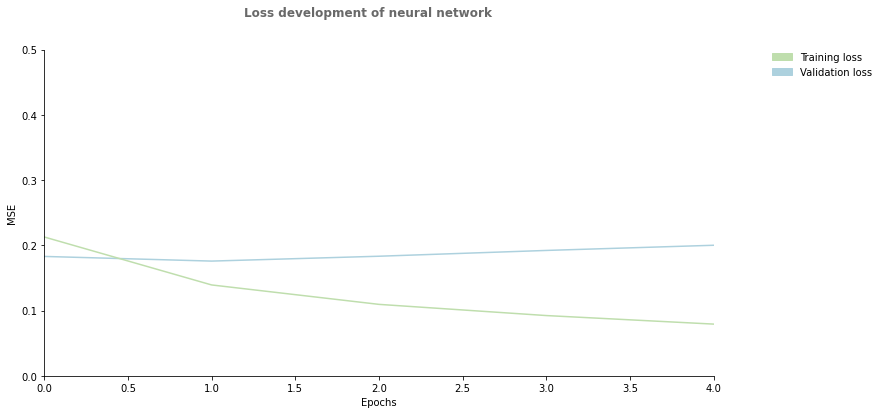

In [61]:
#Visualizing loss development
#Preparing data
losses = pd.DataFrame(model.history.history)

#Creating plot architecture
fig, ax = plt.subplots(figsize = (12, 6), ncols = 1, nrows = 1)
sns.despine(top = True)
fig.suptitle("Loss development of neural network",
             color = "#696969",
             weight = "bold",
             size = 12)

#Plotting
plot = sns.lineplot(x = range(0, len(losses)),
                    y = losses["val_loss"],
                    ax = ax,
                    color = "#add1de")
plot = sns.lineplot(x = range(0, len(losses)),
                    y = losses["loss"],
                    ax = ax,
                    color = "#bfdead")
ax.set_xlabel("Epochs")
ax.set_ylabel("MSE")

#Setting parameters
ax.set_xlim([0, 4])
ax.set_ylim([0, 0.5])

#Setting legend
train_loss = mpatches.Patch(color = "#bfdead", label = "Training loss")
vali_loss = mpatches.Patch(color = "#add1de", label = "Validation loss")
legend = ax.legend(handles = [train_loss, vali_loss], 
                        loc = "upper right", 
                        bbox_to_anchor = (0.9,1.02,0.35,0),
                        frameon = False)


In [62]:
#Generating predictions
y_test_pred_embedding = model.predict(np.array(X_test_seq))
y_test_pred_embedding = pd.Series(np.where(y_test_pred_embedding > 0.5, 1, 0).flatten())

In [63]:
#Evaluating predictions on total test set
print(classification_report(y_test["sentiment"], y_test_pred_embedding))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     30212
           1       0.68      0.55      0.61      3310

    accuracy                           0.93     33522
   macro avg       0.82      0.76      0.78     33522
weighted avg       0.92      0.93      0.93     33522



In [64]:
#Generating predictions
y_test_gold_pred_embedding = model.predict(np.array(X_test_gold_seq))
y_test_gold_pred_embedding = pd.Series(np.where(y_test_gold_pred_embedding > 0.5, 1, 0).flatten())

In [65]:
#Evaluating predictions on gold test set
print(classification_report(y_test_gold["sentiment"], y_test_gold_pred_embedding))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2123
           1       0.37      0.24      0.30       282

    accuracy                           0.86      2405
   macro avg       0.64      0.60      0.61      2405
weighted avg       0.84      0.86      0.85      2405



## Chapter 4: <a class="anchor" id="chapter4"></a> Propagation

In [66]:
#Converting text into integer sequence
X_seq  = tokenizer.texts_to_sequences(X["clause_ABSA"])

In [67]:
#Padding sequence
X_seq  = pad_sequences(X_seq, maxlen = 160)

In [68]:
#Generating predictions
y_pred_embedding = model.predict(np.array(X_seq))

In [69]:
#Joining dataframe
final_df = df_unique.copy()
final_df["prediction"] = y_pred_embedding

In [70]:
#Renaming columns
final_df.rename(columns = {"sentiment": "snorkel_sentiment", 
                           "prediction": "sentiment"}, 
                inplace = True)

In [71]:
#Dropping columns
final_df.drop(["index", "stratification", "sentence_ABSA_subclause", "sentence_ABSA_rel_keywords", "entity_keyword"], 
              axis = 1, 
              inplace = True)

In [73]:
#Saving to CSV
os.chdir("..")
os.chdir("..")
final_df.to_csv("Outputs/Articles/DL/dl.csv")
os.chdir("Notebooks/Articles")